In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from f110_gym.envs.base_classes import Integrator
from collections import Counter,defaultdict
import random
import os
import pickle
import pandas as pd
from collections import defaultdict,deque
import math
import cmath
import scipy.stats as stats
import time
from sklearn.preprocessing import StandardScaler
from scipy.stats import truncnorm
from sklearn.preprocessing import normalize

In [2]:
class Reward:
    def __init__(self, min_speed=0.5, max_speed=1.8, map_centers=None,track_width = 2.2):
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.map_centers = map_centers

        # Initial point and center that detrmines the position at the start of episode
        self.initial_point = np.array([[0, 0]])
        self.initial_center_idx , _ = self.__calculate_distance_from_center(self.map_centers,self.initial_point)
        self.initial_center = self.map_centers[self.initial_center_idx]

        # Race Track parameters
        self.distance_between_centers = np.hstack([[0.],np.linalg.norm(self.map_centers[:-1,:]- self.map_centers[1:,:],axis=1)])
        self.total_track_length = np.sum(self.distance_between_centers)
        self.track_width = track_width

        # Hyperparameters
        self.epsilon = 1e-5
        self.distance_travelled = 0

        # Centering reward function
        self.func = lambda y : 2 * (np.exp(-0.017*y) - 0.5)
    
    def __calculate_distance_from_center(self, centers,curr):
        distances = np.linalg.norm(centers - curr, axis=1)
        idx = np.argmin(distances)
        return idx, distances[idx]

    def reset(self, point):
        self.distance_travelled = 0
        self.initial_point = point
        idx , _ = self.__calculate_distance_from_center(self.map_centers,self.initial_point)
        self.initial_center_idx = idx
        self.initial_center = self.map_centers[self.initial_center_idx]

    def exponential_angle(self, angle):
        if angle <=90:
            return self.func(angle)
        return -1

    def progress_reward(self, curr_position, next_position):
        distance = np.linalg.norm(curr_position - next_position)
        self.distance_travelled += distance
        return self.distance_travelled / self.total_track_length


    def centering_reward(self, curr_position,next_position):
        
        position_vector = next_position - curr_position

        curr_idx, c = self.__calculate_distance_from_center(self.map_centers,curr_position)
        # print(f'Curr position: {curr_position}, Next position: {next_position} with initial center idx: {curr_idx}')

        if curr_idx == self.map_centers.shape[0] - 1:
            indices = [curr_idx-1,0]
        elif curr_idx == 0:
            indices = [self.map_centers.shape[0]-1,curr_idx+1]
        else:
            indices = [curr_idx-1, curr_idx+1]
            
        # print(f'Indices: {indices}')
        # print(np.vstack([self.map_centers[indices[0],:],self.map_centers[indices[1],:]]))

        next_idx, n = self.__calculate_distance_from_center(np.vstack([self.map_centers[indices[0],:],self.map_centers[indices[1],:]]),next_position)
        next_idx = indices[next_idx]
        # print(f'Next index is {next_idx} and distance is {n}')

        curr_center = self.map_centers[curr_idx]
        next_center = self.map_centers[next_idx]

        if curr_idx == next_idx:
            return -1
        
        # print(f'Current center: {curr_center}, Next center: {next_center}')
        center_vector = next_center - curr_center

        angle_rad = np.arccos(np.dot(center_vector, position_vector) / (np.linalg.norm(center_vector) * np.linalg.norm(position_vector)))

        # print(f'Center vector: {center_vector} and Position vector: {position_vector}')

        return self.exponential_angle(np.degrees(angle_rad))
    
    def milestone_reward(self, next_position):
        idx, _ = self.__calculate_distance_from_center(self.map_centers,next_position)
        if idx!=self.initial_center_idx:
            travelled = np.linalg.norm(self.initial_center - next_position) / self.total_track_length
            if  travelled >= np.abs(self.distance_between_centers[idx] - self.distance_between_centers[self.initial_center_idx]) / self.total_track_length :
                self.initial_center_idx = idx
                self.initial_center = self.map_centers[idx]
                return 5
        return 0

    def calculate_reward(self, curr_position, next_position):
        progress_reward = self.progress_reward(curr_position, next_position)
        centering_reward = self.centering_reward(curr_position, next_position)
        milestone_reward = self.milestone_reward(next_position)
        # print(f"Distance reward: {progress_reward}, Centering reward: {centering_reward}, Milestone reward: {milestone_reward}")
        return progress_reward + centering_reward + milestone_reward

In [3]:
class IndexSelector:
    def __init__(self, num_indices):
        self.num_indices = num_indices
        self.visited_indices = set()
        self.probabilities = np.ones(num_indices) / num_indices

    def select_index(self):
        if len(self.visited_indices) == self.num_indices:
            # Reset the probabilities and visited indices
            print('Visited all indices, resetting')
            self.visited_indices = set()
            self.probabilities = np.ones(self.num_indices) / self.num_indices

        # Select an index based on the current probabilities
        random_idx = np.random.choice(np.arange(self.num_indices), p=self.probabilities)

        # Update the probabilities
        self.visited_indices.add(random_idx)
        if len(self.visited_indices) < self.num_indices:
            self.probabilities[random_idx] = 0
            remaining_prob = 1 - np.sum(self.probabilities)
            self.probabilities[self.probabilities > 0] += remaining_prob / np.sum(self.probabilities > 0)

        return random_idx

In [4]:
class F1Tenth_navigation:

    def __init__(self,gym_env_code='f110_gym:f110-v0', num_agents=1, map_path='./f1tenth_racetracks/Austin/Austin_map', map_ext='.png', sx=0., sy=0., stheta=0., map_centers_file=None, save_path=None, track_name=None, inference=None,reward_file=None,collision_file=None):

        # Environment setup
        self.env = gym.make(gym_env_code, map=map_path, map_ext=map_ext, num_agents=num_agents, timestep=0.01, integrator=Integrator.RK4)
        self.env.add_render_callback(self.render_callback)
        self.sx, self.sy, self.stheta = sx, sy, stheta
        self.save_path = save_path
        self.track_name = track_name
        self.num_agents = num_agents
        self.map_path = map_path
        self.map_ext = map_ext
        self.map_centers_file = pd.read_csv(map_centers_file)
        self.map_centers_file.columns = ['x', 'y', 'w_r', 'w_l']
        self.map_centers_file.index = self.map_centers_file.index.astype(int)
        self.map_centers = self.map_centers_file.values[:, :2]
        self.track_width = self.map_centers_file.loc[0,'w_r'] + self.map_centers_file.loc[0,'w_l']
        self.reward_file = reward_file
        self.collision_file = collision_file

        # Random Seed
        self.random_seed = 42
        np.random.seed(self.random_seed)

        # Environment Observation Parameters
        self.num_beams = 1080
        self.n_features = 11
        self.angle = 270

        # Action Space Parameters
        self.num_angles = 51
        self.num_speeds = 10

        # LiDAR downsampling parameters
        self.n_sectors = 30

        # State Space Parameters
        self.num_states = 2 ** self.n_features

        # Speed Parameters
        self.min_speed = 0.8
        self.max_speed = 2

        # Action Space
        self.angles_deg = np.linspace(-self.angle // 2, self.angle // 2, self.num_angles)[::-1]
        self.angles = self.convert_deg_to_rad(self.angles_deg)
        self.speeds = np.linspace(self.min_speed, self.max_speed, self.num_speeds)
    
        # State Space - Q-Table
        if inference is not None:
            self.weights = np.load(inference)
            self.num_collisions = int(inference.split('_')[1].split('.')[0])
            print(f'Loaded Weights')
        else:
            self.weights = np.zeros((self.num_states,self.num_angles,self.num_speeds))
            self.num_collisions = 0


        # ELigibility Trace
        self.ET_IS = np.zeros((self.num_states,self.num_angles,self.num_speeds))

        # projection matrix
        if self.n_features == 10:
            zero_prob = 0.85
            one_prob = 0.15
        if self.n_features == 11:
            zero_prob = 0.8
            one_prob = 0.2
        self.projection_matrix = self.get_projection_matrix(zero_prob=zero_prob,one_prob=one_prob)

        # binary powers
        self.binary_powers = np.array([2 ** i for i in range(self.n_features)])

        # Training Variables
        self.curr_state = None
        self.next_state = None
    
        
        self.action_threshold_decay = 0.99997
        self.action_threshold = 0.20 * (self.action_threshold_decay ** self.num_collisions)

        # Imported Classes
        self.reward_class = Reward(min_speed=self.min_speed, max_speed=self.max_speed, map_centers=self.map_centers, track_width=self.track_width)
        self.index_selector = IndexSelector(self.map_centers.shape[0])      

        # Sarsa Parameters
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.decay_rate = 0.9

        # Reward
        self.reward = 0
        self.episode_reward = 0
        self.cumulative_reward = 0
        self.episodic_rewards = [0]
        self.delayed_reward_counter = 0

        # Time
        self.collision_times = [0]
        

    def render_callback(self, env_renderer):
        e = env_renderer
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def convert_deg_to_rad(self, array):
        return array * np.pi / 180

    def get_statistical_properties(self,lidar_input,n_sectors=30):
        lidar_input = np.asarray(lidar_input, dtype=np.float32)
        sector_size = lidar_input.shape[0] // n_sectors
        sectors = lidar_input[:sector_size * n_sectors].reshape(n_sectors, sector_size)
        medians = np.median(sectors, axis=1)

        return medians.reshape(1, -1)
    
    def binarize_vector(self,vector):
        mi,ma = np.min(vector),np.max(vector)
        threshold = (ma+mi)/2
        return np.where(vector > threshold, 1, 0)
    
    def get_projection_matrix(self,zero_prob=0.5,one_prob=0.5):
        # Generate a random matrix with values 0 and 1 based on the given probabilities [prob_0,prob_1]
        if not os.path.exists('Projection_matrices'):
            os.mkdir('Projection_matrices')
        if not os.path.exists(os.path.join('Projection_matrices', f'projection_{self.n_features}f_s{self.random_seed}.npy')):
            matrix = np.random.choice([0, 1], size=(self.n_sectors, self.n_features), p=[zero_prob,one_prob])
            np.save(os.path.join('Projection_matrices', f'projection_{self.n_features}f_s{self.random_seed}.npy'), matrix)
        else:
            matrix = np.load(os.path.join('Projection_matrices', f'projection_{self.n_features}f_s{self.random_seed}.npy'))
        return matrix
    
    def get_binary_representation(self,lidar_input):
        lidar = normalize(self.get_statistical_properties(lidar_input),axis=1)
        proj = np.dot(lidar,self.projection_matrix)
        binary = self.binarize_vector(proj)
        return binary
    
    def get_state(self, binary):
        return np.dot(binary[0], self.binary_powers)
    
    def select_action(self, state):
        random_number = np.random.rand()
        if random_number < self.action_threshold:
            angle_index = np.random.randint(0, self.num_angles)
            speed_index = np.random.randint(0, self.num_speeds)
        else:
            flattened = self.weights[state].flatten()
            max_value = np.max(flattened)
            max_indices = np.where(flattened == max_value)[0]
            max_index = np.random.choice(max_indices)
            
            angle_index, speed_index = np.unravel_index(max_index, self.weights[state].shape)

        self.action_threshold *= self.action_threshold_decay

        return angle_index, speed_index

    def select_action_inference(self, state):
        
        flattened = self.weights[state].flatten()
        max_value = np.max(flattened)
        max_indices = np.where(flattened == max_value)[0]
        max_index = np.random.choice(max_indices)
        
        angle_index, speed_index = np.unravel_index(max_index, self.weights[state].shape)

        return angle_index, speed_index
    
    def sarsa_weight_update(self,angle_idx,speed_idx,reward):
        next_angle_idx,next_speed_idx = self.select_action(self.next_state)
        delta = reward + self.discount_factor * self.weights[self.next_state,next_angle_idx,next_speed_idx] - self.weights[self.curr_state,angle_idx,speed_idx]

        self.weights += self.learning_rate * delta * self.ET_IS
        return next_angle_idx,next_speed_idx
    
    def set_eligibility_trace(self,angle_idx,speed_idx):
        self.ET_IS [self.curr_state,angle_idx,speed_idx] = 1

    def decay_eligibility_trace(self):
        self.ET_IS *= self.discount_factor * self.decay_rate

    def save_reward_time(self):
        if not os.path.exists(os.path.join(self.save_path, self.track_name)):
            os.mkdir(os.path.join(self.save_path, self.track_name))
        
        if self.reward_file is not None:

            r = np.append(np.load(self.reward_file), self.episodic_rewards[-1])
            t = np.append(np.load(self.collision_file), self.collision_times[-1])
            np.save(os.path.join(self.save_path, self.track_name, f'rewards.npy'), np.array(r))
            np.save(os.path.join(self.save_path, self.track_name, f'times.npy'), np.array(t))
        else:
            np.save(os.path.join(self.save_path, self.track_name, f'rewards.npy'), np.array(self.episodic_rewards))
            np.save(os.path.join(self.save_path, self.track_name, f'times.npy'), np.array(self.collision_times))
    
    def save_weights(self):
        if not os.path.exists(os.path.join(self.save_path, self.track_name)):
            os.mkdir(os.path.join(self.save_path, self.track_name))
        np.save(os.path.join(self.save_path, self.track_name, f'weights_{self.num_collisions + 1}.npy'), self.weights)
        # print(f'File saved')


    def train(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta]]))
        lidar = obs['scans'][0]

        down_sampled = self.get_binary_representation(lidar)
        self.curr_state = self.get_state(down_sampled)
        self.reward_class.reset(np.array([[self.sx, self.sy]]))
        angle_index,speed_index = self.select_action(self.curr_state)
        start_time = time.time()
        while True:
            # np.save(f'./LiDAR_scans/scan_{self.curr_state}.npy',lidar)
            steering_angle,speed = self.angles[angle_index],self.speeds[speed_index]
            curr_x = obs['poses_x'][0]
            curr_y = obs['poses_y'][0]
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            lidar = obs['scans'][0]
            down_sampled = self.get_binary_representation(lidar)
            self.next_state = self.get_state(down_sampled)

            if done:
                self.reward = -50
            else:           
                self.reward = self.reward_class.calculate_reward(np.array([curr_x, curr_y]), np.array([obs['poses_x'][0], obs['poses_y'][0]]))
            # print(f'Reward: {self.reward},Curr_state is {self.curr_state},steering angle: {steering_angle}, speed: {speed}')
            # print(f'State: {self.curr_state}, Next state: {self.next_state}, Reward: {self.reward}')
            self.cumulative_reward += self.reward
            self.episode_reward += self.reward
            self.set_eligibility_trace(angle_index,speed_index)
            if self.delayed_reward_counter == 5:
                angle_index,speed_index = self.sarsa_weight_update(angle_index,speed_index,self.episode_reward)
                self.delayed_reward_counter = 0
                # print(f'Episode reward is {self.episode_reward}')
            else:
                self.delayed_reward_counter += 1
                angle_index,speed_index = self.sarsa_weight_update(angle_index,speed_index,0)
               
            
            self.decay_eligibility_trace()
            self.curr_state = self.next_state

            # Randomize the starting point after collision
            if done:
                _,_ = self.sarsa_weight_update(angle_index,speed_index,self.episode_reward)
                self.num_collisions += 1
                self.episode_reward = 0

                # Obtaining a new random position on the track
                random_idx = self.index_selector.select_index()
                n_x, n_y = self.map_centers[random_idx]
                delta_x, delta_y = np.random.uniform(-0.75, 0.75), np.random.uniform(-0.2, 0.2)
                n_theta = np.random.choice(self.angles)

                # Sensing the new state
                obs, step_reward, done, info = self.env.reset(np.array([[n_x + delta_x, n_y + delta_y, n_theta]]))
                lidar = obs['scans'][0]
                down_sampled = self.get_binary_representation(lidar)
                self.curr_state = self.get_state(down_sampled)
                angle_index,speed_index = self.select_action(self.curr_state)

                # Resetting 
                self.reward_class.reset(np.array([[n_x + delta_x, n_y + delta_y]]))
                self.ET_IS.fill(0)

                # Checkpoint
                if (self.num_collisions + 1) % 1000 == 0:
                    end_time = time.time()
                    print(f'Collision: {self.num_collisions+1}, Time: {end_time - start_time}, Reward: {self.cumulative_reward - self.episodic_rewards[-1]}')
                    self.collision_times.append(end_time - start_time)
                    self.episodic_rewards.append(self.cumulative_reward - self.episodic_rewards[-1])
                    self.save_reward_time()
                    start_time = end_time
                    # self.save_weights()
                if (self.num_collisions + 1) % 2000 == 0:
                    self.save_weights()
            # self.env.render(mode='human')
    
    def inference(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta]]))
        lidar = obs['scans'][0]
        down_sampled = self.get_binary_representation(lidar)
        self.curr_state = self.get_state(down_sampled)
        self.reward_class.reset(np.array([[self.sx, self.sy]]))
        angle_index,speed_index = self.select_action_inference(self.curr_state)
        while not done:
            steering_angle,speed = self.angles[angle_index],self.speeds[speed_index]
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            lidar = obs['scans'][0]
            down_sampled = self.get_binary_representation(lidar)
            self.next_state = self.get_state(down_sampled)
            angle_index,speed_index = self.select_action_inference(self.next_state)
            self.curr_state = self.next_state
            
            self.env.render(mode='human')

In [5]:
path = './f1tenth_racetracks'
all_map_paths=[]
map_centers = []
map_names = []
track_lengths=[]
for folder in os.listdir(path):
    if folder not in ['README.md','.gitignore','convert.py','LICENSE','rename.py','.git']:
        folder_name=folder
        file_name=folder_name.replace(' ','')+'_map'
        map_center = folder_name.replace(' ','')+'_centerline.csv'
        track_lengths.append(len(pd.read_csv(f'{path}/{folder_name}/{map_center}')))
        map_names.append(folder_name)
        all_map_paths.append(f'{path}/{folder_name}/{file_name}')
        map_centers.append(f'{path}/{folder_name}/{map_center}')

list(zip(map_names,track_lengths))

[('Nuerburgring', 1029),
 ('Sakhir', 1082),
 ('IMS', 805),
 ('Spielberg', 864),
 ('Silverstone', 1178),
 ('Hockenheim', 914),
 ('BrandsHatch', 781),
 ('Montreal', 872),
 ('MoscowRaceway', 813),
 ('Monza', 1159),
 ('Zandvoort', 864),
 ('Oschersleben', 739),
 ('Spa', 1401),
 ('Mexico City', 860),
 ('Sochi', 1169),
 ('Catalunya', 931),
 ('Shanghai', 1090),
 ('Austin', 1102),
 ('Melbourne', 1060),
 ('SaoPaulo', 862),
 ('Sepang', 1108),
 ('Budapest', 876),
 ('YasMarina', 1110)]

In [6]:
global num_agents,map_path,map_ext,sx,sy,stheta
num_agents = 1
map_ext = '.png'
sx = 0.
sy = 0.
stheta = 1.0
map_index = 0
map_path = all_map_paths[map_index]
map_center = map_centers[map_index]
map_name = map_names[map_index]
save_path = './Weights/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
# inference_file = None
# reward_file = None
# collision_file = None
inference_file = f'./Weights/{map_name}/weights_14000.npy'
reward_file = f'./Weights/{map_name}/rewards.npy'
collision_file = f'./Weights/{map_name}/times.npy'
simulator = F1Tenth_navigation(num_agents=num_agents,map_path=map_path,map_ext=map_ext,sx=sx,sy=sy,stheta=stheta,map_centers_file=map_center,save_path=save_path,track_name=map_name,inference=inference_file,reward_file=reward_file,collision_file=collision_file)
simulator.train()
# simulator.inference()

/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Collision: 15000, Time: 585.310507774353, Reward: -91320.37034722583
Visited all indices, resetting
Collision: 16000, Time: 826.8245227336884, Reward: -74840.28122168916
Visited all indices, resetting
Collision: 17000, Time: 681.02219414711, Reward: -168872.6348969061
Visited all indices, resetting
Collision: 18000, Time: 883.4041042327881, Reward: -146843.67015354056
Visited all indices, resetting
Collision: 19000, Time: 1082.2788515090942, Reward: -205953.4652370757
Visited all indices, resetting
Collision: 20000, Time: 1943.6757895946503, Reward: -104587.15283241868
Visited all indices, resetting
Collision: 21000, Time: 689.0042140483856, Reward: -283848.83742493007
Visited all indices, resetting
Collision: 22000, Time: 1109.590113401413, Reward: -153074.85477007896
Visited all indices, resetting
Collision: 23000, Time: 1166.6542656421661, Reward: -320675.55182062
Visited all indices, resetting
Collision: 24000, Time: 2157.351235151291, Reward: -106394.68076673121
Vis

KeyboardInterrupt: 

In [7]:
reward = np.load('/workspaces/f1_tenth/Weights/Nuerburgring/rewards.npy')
times = np.load('/workspaces/f1_tenth/Weights/Nuerburgring/times.npy')

In [8]:
path = '/workspaces/f1_tenth/Weights/Nuerburgring'
episode_num=[0]
for file in os.listdir(path):
    if file.startswith('weights'):
        episode_num.append(int(int(file.split('_')[1].split('.')[0])/1000))

episode_num = sorted(episode_num) 

In [9]:
reward

array([      0.        ,  -79535.94902776,  -25006.54410035,
       -166061.02984721, -107453.82287625, -261833.96684248,
       -158673.83851447, -315980.07259617, -236557.59295548,
       -407373.35253638, -317926.065441  , -399390.14734744,
       -284940.5802288 , -467390.73916174, -180263.54558024,
        -91320.37034723,  -74840.28122169, -168872.63489691,
       -146843.67015354, -205953.46523708, -104587.15283242,
       -283848.83742493, -153074.85477008, -320675.55182062,
       -106394.68076673, -299233.89846245, -191018.09510652,
       -384321.91180098,  577001.49574265])

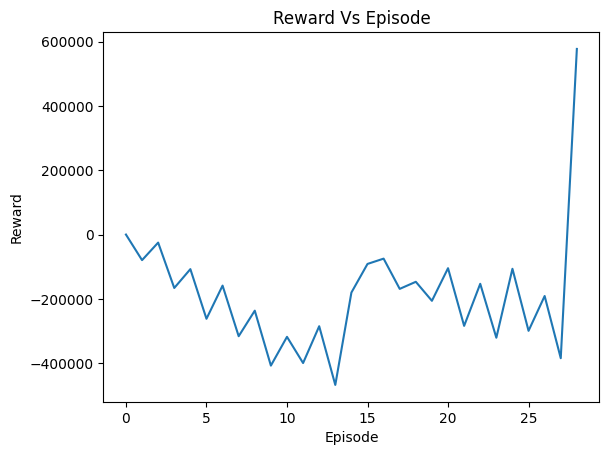

In [10]:
plt.plot(list(range(episode_num[-1]+1)),reward)
plt.title('Reward Vs Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [11]:
times

array([   0.        ,  842.52815866, 1410.85441637,  750.2742579 ,
        709.66517854,  477.87067604,  712.74386835,  747.11329412,
        704.8676672 ,  523.7243042 ,  671.54631519, 1402.85998559,
       1725.71169591,  649.4277277 , 2380.49737239,  585.31050777,
        826.82452273,  681.02219415,  883.40410423, 1082.27885151,
       1943.67578959,  689.00421405, 1109.5901134 , 1166.65426564,
       2157.35123515, 1747.0507319 ,  747.84767032,  625.48452282,
       7134.63174415])

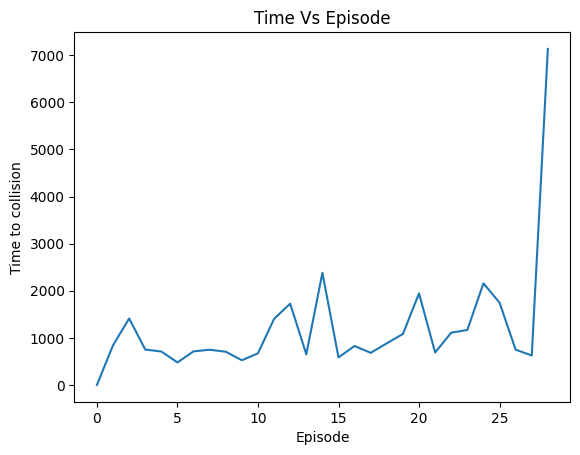

In [12]:
plt.plot(list(range(episode_num[-1]+1)),times)
plt.title('Time Vs Episode')
plt.xlabel('Episode')
plt.ylabel('Time to collision')
plt.show()